# Neural Machine Translation
Welcome to your first programming assignment for this week!

- You will build a Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25").
- You will do this using an attention model, one of the most sophisticated sequence-to-sequence models.

In [8]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import sys
print("Python version:", sys.version)
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)

Python version: 3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
TensorFlow: 2.3.0
NumPy: 1.18.5


# Translating Human Readable Dates Into Machine Readable Dates
- The model you will build here could be used to translate from one language to another, such as translating from English to Hindi.
- However, language translation requires massive datasets and usually takes days of training on GPUs.
- To give you a place to experiment with these models without using massive datasets, we will perform a simpler "date translation" task.
- The network will input a date written in a variety of possible formats (e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987")
- The network will translate them into standardized, machine readable dates (e.g. "1958-08-29", "1968-03-30", "1987-06-24").
- We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD.

## 1.1 - Dataset
We will train the model on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples.

In [9]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 25473.86it/s]


In [10]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('monday august 19 2024', '2024-08-19'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('22 may 1988', '1988-05-22'),
 ('8 jul 2008', '2008-07-08'),
 ('wednesday september 8 1999', '1999-09-08')]

- dataset: a list of tuples of (human readable date, machine readable date).
- human_vocab: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- machine_vocab: a python dictionary mapping all characters used in machine readable dates to an integer-valued index.
    - Note: These indices are not necessarily consistent with human_vocab.
- inv_machine_vocab: the inverse dictionary of machine_vocab, mapping from indices back to characters.
Let's preprocess the data and map the raw text data into the index values.

- We will set Tx=30
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set Ty=10
    - "YYYY-MM-DD" is 10 characters long.

In [11]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


- X: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using human_vocab.
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >).
    - X.shape = (m, Tx) where m is the number of training examples in a batch.
- Y: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in machine_vocab.
    - Y.shape = (m, Ty).
- Xoh: one-hot version of X
    - Each index in X is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0.
    - Xoh.shape = (m, Tx, len(human_vocab))
- Yoh: one-hot version of Y
    - Each index in Y is converted to the one-hot representation.
    - Yoh.shape = (m, Ty, len(machine_vocab)).
    - len(machine_vocab) = 11 since there are 10 numeric digits (0 to 9) and the - symbol.
- Let's also look at some examples of preprocessed training examples.
- Feel free to play with index in the cell below to navigate the dataset and see how source/target dates are preprocessed.

In [12]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# 2 - Neural Machine Translation with Attention
- If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate.
- Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down.
- The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step.

## 2.1 - Attention Mechanism
In this part, you will implement the attention mechanism presented in the lecture videos.

Here is a figure to remind you how the model works.
- The diagram on the left shows the attention model.
- The diagram on the right shows what one "attention" step does to calculate the attention variables $α^{<t, \; t^ \prime>}$.
- The attention variables $α^{<t, \; t^ \prime>}$ are used to compute the context variable $context^{<t>}$ for each timestep in the output (t=1,...,$T_y$).

![Attention](images/attention.png)

## Pre-attention and Post-attention LSTMs on both sides of the attention mechanism
- There are two separate LSTMs in this model (see diagram on the left): pre-attention and post-attention LSTMs.

- Pre-attention Bi-LSTM is the one at the bottom of the picture is a Bi-directional LSTM and comes before the attention mechanism.

    - The attention mechanism is shown in the middle of the left-hand diagram.
    - The pre-attention Bi-LSTM goes through $T_x$ time steps
- Post-attention LSTM: at the top of the diagram comes after the attention mechanism.

    - The post-attention LSTM goes through $T_y$ time steps.
- The post-attention LSTM passes the hidden state $s^{<t>}$ and cell state $c^{<t>}$
 from one time step to the next.

## An LSTM has both a hidden state and cell state
- In the lecture videos, we were using only a basic RNN for the post-attention sequence model
    - This means that the state captured by the RNN was outputting only the hidden state $s^{<t>}$.
- In this assignment, we are using an LSTM instead of a basic RNN.
So the LSTM has both the hidden state $s^{<t>}$ and the cell state $c^{<t>}$.

## Each time step does not use predictions from the previous time step
- Unlike previous text generation examples earlier in the course, in this model, the post-attention LSTM at time __t__ does not take the previous time step's prediction $y^{<t-1>}$ as input.
- The post-attention LSTM at time 't' only takes the hidden state $s^{<t>}$ and cell state $c^{<t>}$ as input.
- We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

## Concatenation of hidden states from the forward and backward pre-attention LSTMs
- $\vec a^{<t>}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow a^{<t>}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{<t>} = [\vec a^{<t>}, \overleftarrow a^{<t>}]$: the concatenation of the activations of both the forward-direction $\vec a^{<t>}$ and backward-directions $\overleftarrow a^{<t>}$ of the pre-attention Bi-LSTM.

## Computing "energies" $e^{<t, t ^\prime >}$ as a function of $s^{<t-1>} and \; a^{<t^\prime>}$
 
- Recall in the lesson videos "Attention Model", at time 6:45 to 8:16, the definition of "e" as a function of $s^{<t-1>}$
 and $a^{<t>}$.

    - "e" is called the "energies" variable.
    - $s^{<t-1>}$ is the hidden state of the post-attention LSTM
    - $a^{<t^\prime>}$ is the hidden state of the pre-attention LSTM.
    - $s^{<t-1>}$ and $a^{<t>}$ are fed into a simple neural network, which learns the function to output $e^{<t, t^\prime>}$.
    - $e^{<t, t^\prime>}$ is then used when computing the attention $α^{<t, t^\prime>}$ that  $y^{<t>}$ should pay to  $a^{<t^\prime>}$ .

## Diagram on the right
- The diagram on the right of figure 1 uses a RepeatVector node to copy $s^{<t-1>}$'s value $T_x$ times.
- Then it uses Concatenation to concatenate  $s^{<t-1>}$ and $a^{<t>}$.
- The concatenation of  $s^{<t-1>}$ and $a^{<t>}$ is fed into a "Dense" layer, which computes $e^{<t, t^\prime>}$.
- $e^{<t, t^\prime>}$ is then passed through a softmax to compute $α^{<t, t^\prime>}$.
- Note that the diagram doesn't explicitly show variable $e^{<t, t^\prime>}$, but $e^{<t, t^\prime>}$ is above the Dense layer and below the Softmax layer in the diagram in the right half of figure 1.
- We'll explain how to use RepeatVector and Concatenation in Keras below.

# Implementation Details
Let's implement this neural translator. You will start by implementing two functions: one_step_attention() and model().

# one_step_attention
- The inputs to the one_step_attention at time step __t__ are:
    - [$a^{<1>}, a^{<2>},..., a^{<T_x>} $] : all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$ : the previous hidden state of the post-attention LSTM
- one_step_attention computes:
    - [$α^{<t,1>}, α^{<t,2>},..., α^{<t,T_x>} $]: the attention weights
    - $context^{<t>}$: the context vector:
$$context^{<t>} = \sum_{t^\prime=1}^{T_x}\; α^{<t,t^\prime>} \; a^{<t^\prime>}\tag{1} $$

## Clarifying 'context' and 'c'
In the lecture videos, the context was denoted  $c^{<t>}$
In the assignment, we are calling the context  $context^{<t>}$.
This is to avoid confusion with the post-attention LSTM's internal memory cell variable, which is also denoted $c^{<t>}$.

# Exercise 1 - one_step_attention
Implement one_step_attention().

- The function model() will call the layers in one_step_attention() $T_y$ times using a for-loop.
- It is important that all $T_y$ copies have the same weights.
    - It should not reinitialize the weights every time.
    - In other words, all $T_y$ steps should have shared weights.
- Here's how you can implement layers with shareable weights in Keras:
1. Define the layer objects in a variable scope that is outside of the one_step_attention function. For example, defining the objects as global variables would work.
    - Note that defining these variables inside the scope of the function model would technically work, since model will then call the one_step_attention function. For the purposes of making grading and troubleshooting easier, we are defining these as global variables. Note that the automatic grader will expect these to be global variables as well.

2. Call these objects when propagating the input.
- We have defined the layers you need as global variables.
    - Please run the following cells to create them.
    - Please note that the automatic grader expects these global variables with the given variable names. For grading purposes, please do not rename the global variables.
- Please check the Keras documentation to learn more about these layers. The layers are functions. Below are examples of how to call these functions.
    - [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)   

var_repeated = repeat_layer(var1)
* [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)   
concatenated_vars = concatenate_layer([var1,var2,var3])
* [Dense()](https://keras.io/layers/core/#dense)  
var_out = dense_layer(var_in)
* [Activation()](https://keras.io/layers/core/#activation)  
activation = activation_layer(var_in)  
* [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)  
dot_product = dot_layer([var1,var2])

In [15]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [16]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev) 
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a,s_prev]) 
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat) 
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e) 
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies) 
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a]) 
    ### END CODE HERE ###
    
    return context

In [17]:
# UNIT TEST
def one_step_attention_test(target):

    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    #np.random.seed(10)
    a = np.random.uniform(1, 0, (m, Tx, 2 * n_a)).astype(np.float32)
    s_prev =np.random.uniform(1, 0, (m, n_s)).astype(np.float32) * 1
    context = target(a, s_prev)
    
    assert type(context) == tf.python.framework.ops.EagerTensor, "Unexpected type. It should be a Tensor"
    assert tuple(context.shape) == (m, 1, n_s), "Unexpected output shape"
    assert np.all(context.numpy() > 0), "All output values must be > 0 in this example"
    assert np.all(context.numpy() < 1), "All output values must be < 1 in this example"

    #assert np.allclose(context[0][0][0:5].numpy(), [0.50877404, 0.57160693, 0.45448175, 0.50074816, 0.53651875]), "Unexpected values in the result"
    print("\033[92mAll tests passed!")
    
one_step_attention_test(one_step_attention)

All tests passed!


# Exercise 2 - modelf
Implement modelf() as explained in figure 1 and the instructions:

- modelf first runs the input through a Bi-LSTM to get $[a^{<1>}, a^{<2>},..., a^{<T_x>}]$.
- Then, modelf calls one_step_attention() $T_y$
 times using a for loop. At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat y^{<t>}$.

Again, we have defined global layers that will share weights to be used in modelf().

In [19]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # Please do not modify this global variable.
output_layer = Dense(len(machine_vocab), activation=softmax)

In [20]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model

def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True),input_shape=(m, Tx, n_a*2))(X) 
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state = [s, c] ) 
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [21]:
# UNIT TEST
from test_utils import *

def modelf_test(target):
    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    len_human_vocab = 37
    len_machine_vocab = 11
    
    
    model = target(Tx, Ty, n_a, n_s, len_human_vocab, len_machine_vocab)
    
    print(summary(model))

    
    expected_summary = [['InputLayer', [(None, 30, 37)], 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['Bidirectional', (None, 30, 64), 17920],
                         ['RepeatVector', (None, 30, 64), 0, 30],
                         ['Concatenate', (None, 30, 128), 0],
                         ['Dense', (None, 30, 10), 1290, 'tanh'],
                         ['Dense', (None, 30, 1), 11, 'relu'],
                         ['Activation', (None, 30, 1), 0],
                         ['Dot', (None, 1, 64), 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['LSTM',[(None, 64), (None, 64), (None, 64)], 33024,[(None, 1, 64), (None, 64), (None, 64)],'tanh'],
                         ['Dense', (None, 11), 715, 'softmax']]

    assert len(model.outputs) == 10, f"Wrong output shape. Expected 10 != {len(model.outputs)}"

    comparator(summary(model), expected_summary)
    

modelf_test(modelf)

[['InputLayer', [(None, 30, 37)], 0], ['InputLayer', [(None, 64)], 0], ['Bidirectional', (None, 30, 64), 17920], ['RepeatVector', (None, 30, 64), 0, 30], ['Concatenate', (None, 30, 128), 0], ['Dense', (None, 30, 10), 1290, 'tanh'], ['Dense', (None, 30, 1), 11, 'relu'], ['Activation', (None, 30, 1), 0], ['Dot', (None, 1, 64), 0], ['InputLayer', [(None, 64)], 0], ['LSTM', [(None, 64), (None, 64), (None, 64)], 33024, [(None, 1, 64), (None, 64), (None, 64)], 'tanh'], ['Dense', (None, 11), 715, 'softmax']]
All tests passed!


In [22]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [23]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[10][0]         

In [25]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999,decay=0.01) 
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
### END CODE HERE ###

In [26]:
# UNIT TESTS
assert opt.lr == 0.005, "Set the lr parameter to 0.005"
assert opt.beta_1 == 0.9, "Set the beta_1 parameter to 0.9"
assert opt.beta_2 == 0.999, "Set the beta_2 parameter to 0.999"
assert opt.decay == 0.01, "Set the decay parameter to 0.01"
assert model.loss == "categorical_crossentropy", "Wrong loss. Use 'categorical_crossentropy'"
assert model.optimizer == opt, "Use the optimizer that you have instantiated"
assert model.compiled_metrics._user_metrics[0] == 'accuracy', "set metrics to ['accuracy']"

print("\033[92mAll tests passed!")

All tests passed!


In [27]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [28]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 [==============================] - 3s 31ms/step - loss: 16.2698 - dense_5_loss: 1.0737 - dense_5_1_loss: 0.9783 - dense_5_2_loss: 1.7401 - dense_5_3_loss: 2.6599 - dense_5_4_loss: 0.7536 - dense_5_5_loss: 1.2643 - dense_5_6_loss: 2.6591 - dense_5_7_loss: 0.9359 - dense_5_8_loss: 1.6838 - dense_5_9_loss: 2.5212 - dense_5_accuracy: 0.6038 - dense_5_1_accuracy: 0.7445 - dense_5_2_accuracy: 0.2813 - dense_5_3_accuracy: 0.0967 - dense_5_4_accuracy: 0.9626 - dense_5_5_accuracy: 0.3377 - dense_5_6_accuracy: 0.0474 - dense_5_7_accuracy: 0.9421 - dense_5_8_accuracy: 0.2568 - dense_5_9_accuracy: 0.1208


Thus, `dense_2_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data.
We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our model will save you time.)

In [31]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

source: 3 May 1979
output: 1993-03-03 

source: 5 April 09
output: 1994-04-04 

source: 21th of August 2016
output: 2001-02-22 

source: Tue 10 Jul 2007
output: 2000-02-22 

source: Saturday May 9 2018
output: 1987-09-23 

source: March 3 2001
output: 2003-03-23 

source: March 3rd 2001
output: 2003-03-23 

source: 1 March 2001
output: 2001-02-23 



# 3 - Visualizing Attention (Optional / Ungraded)
Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (such as the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can visualize what each part of the output is looking at which part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha ^{<t,t^\prime>}$
 we get this:

<Figure size 640x480 with 0 Axes>

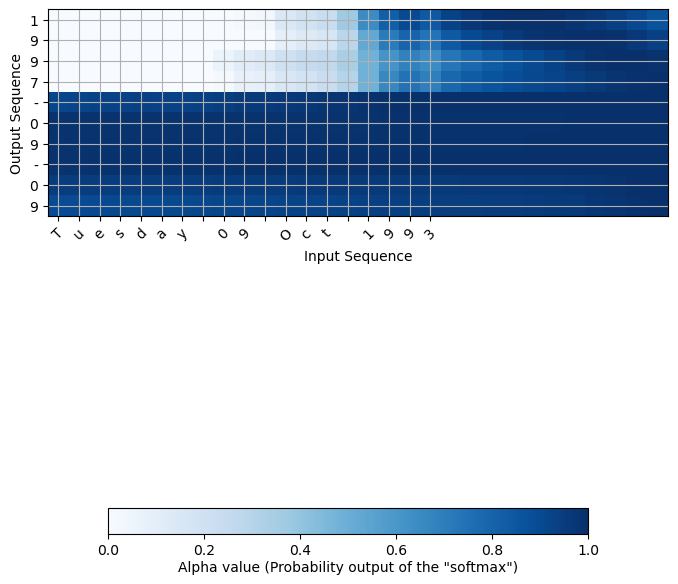

In [32]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);